In [17]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [18]:
import torch
import pandas as pd
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,random_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [19]:
ratings = pd.read_csv("..\\ratings_small.csv")

In [20]:
num_usr, num_movies, num_ratings,_= ratings.max()
num_usr = int(num_usr) + 1
num_movies = int(num_movies) + 1

In [21]:
lookback_window = 4
user_ids = ratings.userId.unique()

# List to hold individual tensors for each user
user_tensors = []

# Iterate over each user and create their individual tensors
for user_id in user_ids:
    # Select data for the current user
    user_data = ratings[ratings['userId'] == user_id]
    
    # Sort the data based on the timestamp
    sorted_data = user_data.sort_values('timestamp')
    
    # Convert the sorted data to a tensor
    user_tensor = torch.stack([
        torch.tensor(sorted_data['userId'].values),
        torch.tensor(sorted_data['movieId'].values),
        torch.tensor(sorted_data['rating'].values),
        torch.tensor(sorted_data['timestamp'].values)
    ]).T
    
    # Roll on the first dimension to create tensors of size [13, 4]
    rolled_tensor = user_tensor.unfold(0, lookback_window, 1)
    
    # Append the rolled tensor to the list
    user_tensors.append(rolled_tensor)

dataset = torch.cat(user_tensors, dim=0).permute(0,2,1)

In [22]:
dataset = dataset[:,:,1:-1] 

In [23]:
dataset.shape      # movieId , rating

torch.Size([97991, 4, 2])

In [24]:
def learning(model, data_loader, loss_module, optimizer, num_epochs, device):
    model.train()
    t_losses = []

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        losses = 0
        for (data_inp, data_token, data_rating) in data_loader:
            data_inp = data_inp.to(device).to(torch.int64)
            data_token = data_token.to(device).to(torch.int64)
            data_rating = data_rating.to(device).to(torch.float32)


            optimizer.zero_grad()
            
            preds = model(data_inp, data_token)


            loss = loss_module(preds, data_rating)

            loss.backward()
            optimizer.step()
            losses += loss.item()
        e = losses/len(data_loader)
        t_losses.append(e)
        pbar.set_description(f"Epoch {epoch+1} the training loss is : {e}")
    return model, t_losses

@torch.no_grad()
def eval_model(model, loss_module, data_loader, device):
    model.eval() # Set model to eval mode
    losses = []
    losse=0
    for (data_inp, data_token, data_rating) in data_loader:
        data_inp = data_inp.to(device).to(torch.int64)
        data_token = data_token.to(device).to(torch.int64)
        data_rating = data_rating.to(device).to(torch.float32)



        # Determine prediction of model on dev set
        preds = model(data_inp, data_token)
        loss = loss_module(preds, preds)
        losses.append(loss.item())
        losse += loss.item()
            
    return losses ,losse/len(data_loader)


In [25]:

class Encoder(nn.Module):
    def __init__(self, embedd_size, embedding_size, hidden_size, num_layers=2, p=0.5):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lin = nn.Linear(1, embedding_size)

        self.embedding = nn.Embedding(embedd_size, embedding_size)
        self.rnn = nn.GRU(2*embedding_size, hidden_size, num_layers, dropout=p)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x shape: (seq_length, N, 2) where N is batch size

        rate = self.dropout(self.relu(self.lin(x[:,:,1].unsqueeze(-1).to(torch.float32))))
        embedding = self.dropout(self.embedding(x[:,:,0]))
        # embedding shape: (seq_length, N, embedding_size)

        _, hidden = self.rnn(torch.cat([rate, embedding], dim=-1))
        # outputs shape: (seq_length, N, hidden_size)

        return hidden


class Decoder(nn.Module):
    def __init__(
        self, embedd_size, embedding_size, hidden_size, output_size, num_layers=2, p=0.5
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(embedd_size, embedding_size)
        self.lin = nn.Linear(embedding_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, hidden):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        x = x.unsqueeze(0).to(torch.int)
        
    
        embedding = self.dropout(self.embedding(x))
        
        # embedding shape: (1, N, embedding_size)
        embedding = self.relu(self.dropout(self.lin(embedding)))

        outputs, hidden = self.rnn(embedding, hidden)
        # outputs shape: (1, N, hidden_size)

        predictions = self.relu(self.fc(outputs))

        # predictions shape: (1, N, 1) to send it to
        # just gonna remove the first dim
        predictions = predictions.squeeze(0).squeeze(-1)

        return predictions, hidden


class RecSys(nn.Module):
    def __init__(self, num_items, embedding_size, hidden_size, num_layers, device, p=0.5):
        super(RecSys, self).__init__()

        self.encoder = Encoder(num_items, embedding_size, hidden_size, num_layers, p)
        self.decoder = Decoder(num_items, embedding_size, hidden_size, 1, num_layers, p)
        self.device = device
        self.to(device)

    def forward(self, source, decode_token): # source : <B, S, 2> , decode_token: <B>
        hidden = self.encoder(source.permute((1,0,2)))

        # Grab the first input to the Decoder which will be <SOS> token
        x = decode_token
        
        # Use previous hidden, cell as context from encoder at start
        output, _ = self.decoder(x, hidden)

        return output

In [26]:
class RecSys_ds(Dataset):
    def __init__(self, data, lookback_window) :
        super().__init__()
        self.data = data
        self.lookback_window = lookback_window

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx,:self.lookback_window - 1] # <‌B, window - 1, 2>
        d_tok = self.data[idx, self.lookback_window - 1, 0] # <B, 1>
        y = self.data[idx, self.lookback_window - 1, 1] # <B , 1>
        return (x, d_tok, y)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
model = RecSys(num_movies, 128, 256, 3, device)

In [29]:
recsys_ds = RecSys_ds(dataset, lookback_window)

In [30]:
batch_size = 64
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate the number of samples for each split
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size


# Perform the train-test split
train_dataset, test_dataset = random_split(recsys_ds, [train_size, test_size])

# Create data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [31]:
num_epochs = 50
lr=0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lossModule = nn.MSELoss()

In [32]:
model, t_losses = learning(model, train_loader, lossModule, optimizer, num_epochs, device)

  0%|          | 0/50 [00:00<?, ?it/s]

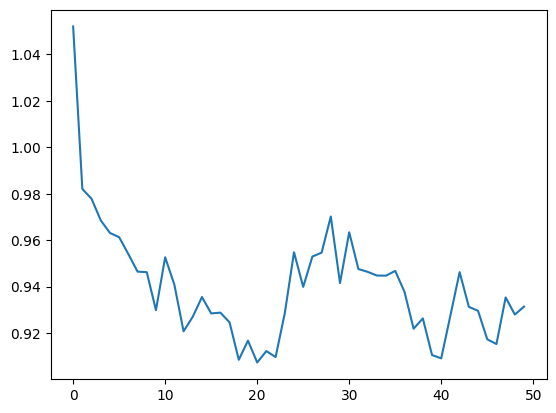

In [33]:
plt.plot(t_losses)

In [37]:
losses, loss = eval_model(model, lossModule, test_loader, device)

In [40]:
loss

0.0

In [44]:
import numpy as np
usr_hist = np.array([
    [23,3],
    [10,5],
    [22,8],
])

In [45]:
usr_hist.shape

(3, 2)